# K2-100
- construct basis from Gaussian + derivatives
- fit time-series of CCFs in that way
- look at time-dependence of coefficients

Suzanne Aigrain @ Oxford, March 2020

In [1]:
%pylab inline
import pickle
from scipy.optimize import minimize
from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


### Read in K2-100 data

In [16]:
from glob import glob
from os.path import basename
from astropy.io import fits as pf
from scipy.interpolate import interp1d
bad = np.array(['HARPN.2015-11-25T04-43-37.896', \
                'HARPN.2015-11-25T05-14-02.591', \
                'HARPN.2015-11-26T05-14-30.980', \
                'HARPN.2015-11-26T05-34-56.137', \
                'HARPN.2015-12-16T03-56-15.063'])
def read_ccfs(doPlot = True):
    ccf_files = np.sort(glob('/Data/HARPSN_K2_100/HARPN*_ccf_G2_A.fits'))
    nobs = len(ccf_files)
    n = len(bad[0])
    good = np.ones(nobs,'bool')
    for i in range(nobs):
        f = ccf_files[i]
        v = basename(f)
        if v[:n] in bad:
            good[i] = False
            print('skipping file', f)
    ccf_files = ccf_files[good]
    nobs = len(ccf_files)    
    for i in range(nobs):
        with pf.open(ccf_files[i]) as hdul:
            if i == 0:
                hdr = hdul[0].header
                nvel = int(hdr['NAXIS1'])
                vels = float(hdr['CRVAL1']) + float(hdr['CDELT1']) * np.arange(nvel)
                ccfs = np.zeros((nobs,nvel))
                ccf = hdul[0].data[-1,:]
            else:
                hdr = hdul[0].header
                nvel_ = int(hdr['NAXIS1'])
                if nvel_ != nvel:
                    ccf_ = hdul[0].data[-1,:]
                    vels_ = float(hdr['CRVAL1']) + float(hdr['CDELT1']) * np.arange(nvel_)
                    g = interp1d(vels_,ccf_)
                    ccf = g(vels)
                else:
                    ccf = hdul[0].data[-1,:]
            s = np.argsort(ccf)
            m = np.median(ccf[s[int(0.9*nvel):]])
            ccfs[i,:] = ccf / m
    if doPlot:
        plt.figure(figsize=(16,6))
        ccfRef = np.mean(ccfs,axis=0)
        plt.imshow((ccfs - ccfRef))
    return vels, ccfs

skipping file /Data/HARPSN_K2_100/HARPN.2015-11-25T04-43-37.896_ccf_G2_A.fits
skipping file /Data/HARPSN_K2_100/HARPN.2015-11-25T05-14-02.591_ccf_G2_A.fits
skipping file /Data/HARPSN_K2_100/HARPN.2015-11-26T05-14-30.980_ccf_G2_A.fits
skipping file /Data/HARPSN_K2_100/HARPN.2015-11-26T05-34-56.137_ccf_G2_A.fits
skipping file /Data/HARPSN_K2_100/HARPN.2015-12-16T03-56-15.063_ccf_G2_A.fits


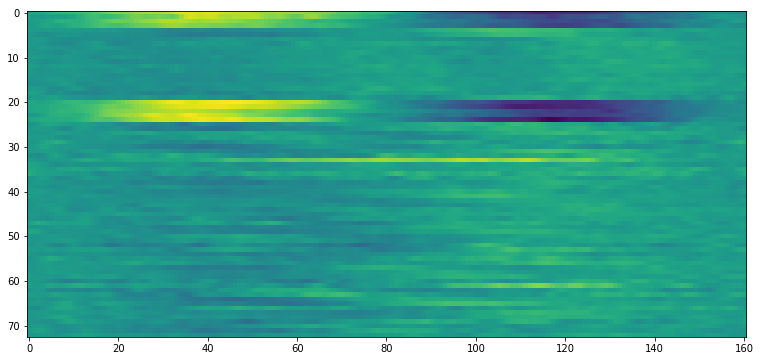

In [17]:
vels, ccfs = read_ccfs()

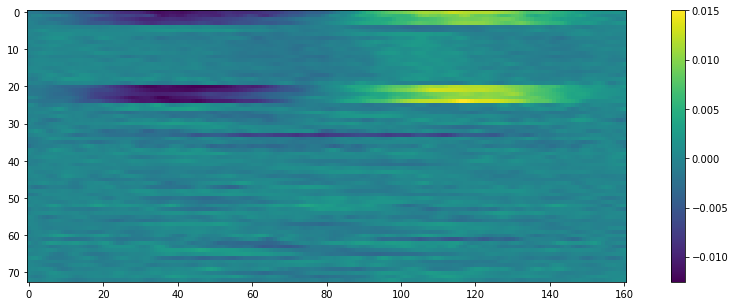

In [39]:
iref = 10
x = vels
y = 1 - ccfs
yref = y[40:70,:].mean(axis=0)
plt.figure(figsize=(16,5))
plt.imshow((y-yref))
plt.colorbar()

### Construct basis

[  0.08784422 -13.81551056   0.           2.30258509]


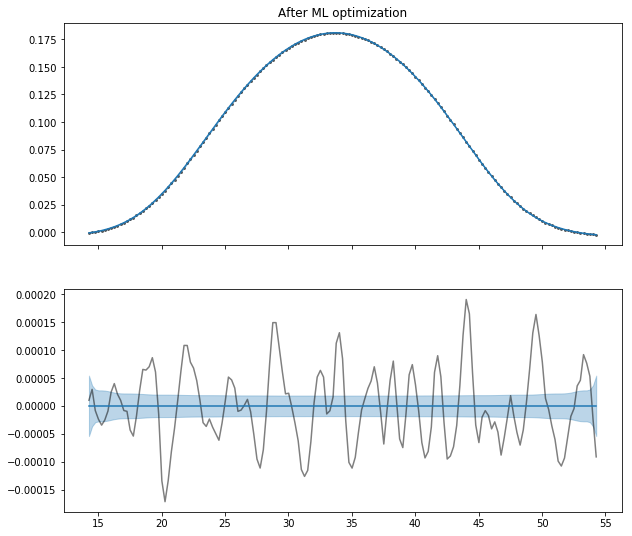

In [40]:
from george import kernels, GP
k = 1.0 * kernels.ExpSquaredKernel(10.0)
gp = GP(k,mean=np.mean(y), fit_mean=True, white_noise = np.log(1e-6), fit_white_noise=True)
print(gp.get_parameter_vector())
def nllGP(p,x,y):
    if (abs(p[2:])>10).any():
        return 1e25        
    gp.set_parameter_vector(p)
    try:
        gp.compute(x)
    except:
        return 1e25
    return -gp.lnlikelihood(y, quiet=True)
p0 = gp.get_parameter_vector()
soln = minimize(nllGP,p0,args=(x,yref))
p1 = soln.x
gp.set_parameter_vector(p1)
mu, var = gp.predict(yref, x, return_var=True)
std = np.sqrt(var)
fig,axes = plt.subplots(2,1,figsize=(10,9),sharex = True)
axes[0].set_title('After ML optimization')
axes[0].plot(x,yref, 'k.', ms = 4, alpha = 0.5)
axes[0].plot(x,mu)
axes[0].fill_between(x,mu+std,mu-std,alpha=0.3,color='C0')
axes[1].plot(x,yref-mu, 'k-', ms = 4, alpha = 0.5)
axes[1].plot(x,mu-mu)
axes[1].fill_between(x,std,-std,alpha=0.3,color='C0')

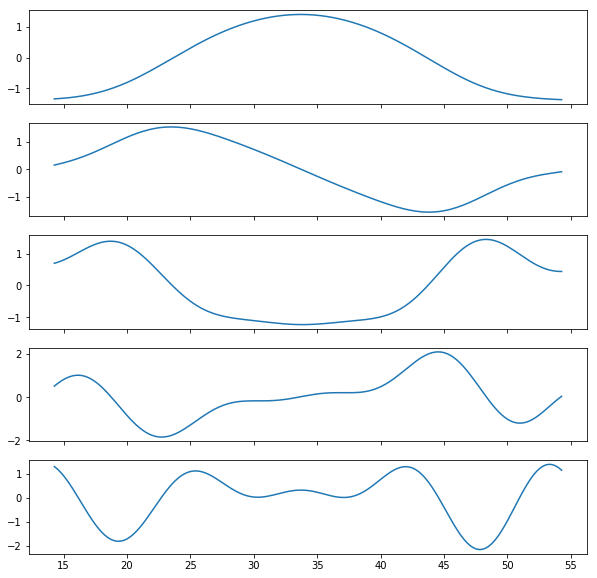

In [41]:
nder = 4
nb = 1 + nder
nvel = len(x)
basis = np.zeros((nb+1,nvel))

newp = k.get_parameter_vector()
newp[1] = np.exp(newp[1])
gp.set_parameter('mean:value',0.0)
g = gp.predict(yref,x,return_var=False,return_cov=False)
gmean, gstd = g.mean(), g.std()
basis[0,:] = (g - gmean) / gstd

kp = 1.0 * kernels.ExpSquaredPrimeKernel(10.0)
kp.set_parameter_vector(newp)
g = gp.predict(yref,x,kernel=kp,return_var=False,return_cov=False)
gmean, gstd = g.mean(), g.std()
basis[1,:] = (g - gmean) / gstd

kp = 1.0 * kernels.ExpSquaredDoublePrimeKernel(10.0)
kp.set_parameter_vector(newp)
g = gp.predict(yref,x,kernel=kp,return_var=False,return_cov=False)
gmean, gstd = g.mean(), g.std()
basis[2,:] = (g - gmean) / gstd

kp = 1.0 * kernels.ExpSquaredTriplePrimeKernel(10.0)
kp.set_parameter_vector(newp)
g = gp.predict(yref,x,kernel=kp,return_var=False,return_cov=False)
gmean, gstd = g.mean(), g.std()
basis[3,:] = (g - gmean) / gstd

kp = 1.0 * kernels.ExpSquaredQuadruplePrimeKernel(10.0)
kp.set_parameter_vector(newp)
g = gp.predict(yref,x,kernel=kp,return_var=False,return_cov=False)
gmean, gstd = g.mean(), g.std()
basis[4,:] = (g - gmean) / gstd

basis[-1,:]=1.0

fig,axes = plt.subplots(nb,1,sharex=True,figsize=(10,2*nb))
for ib in range(nb):
    axes[ib].plot(x,basis[ib,:])    

[ 6.62104272e-02 -7.33971305e-08  1.83466030e-06 -7.94495366e-08
  8.61456746e-07  8.79308767e-02]


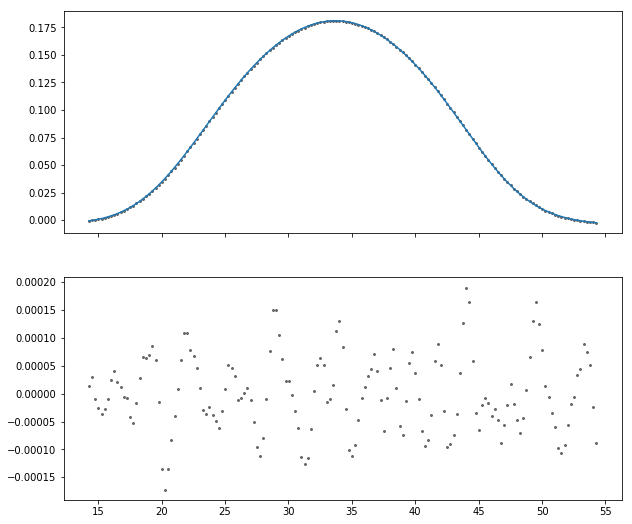

In [42]:
p0 = np.zeros(nb+1)
p0[0] = 1.0
soln = minimize(nllBasis,p0,args=(basis,yref))
p1 = soln.x
print(p1)
m = np.dot(p1,basis)
fig,axes = plt.subplots(2,1,figsize=(10,9),sharex = True)
axes[0].plot(x,yref, 'k.', ms = 4, alpha = 0.5)
axes[0].plot(x,m)
axes[1].plot(x,yref-m, 'k.', ms = 4, alpha = 0.5)

In [44]:
yfit = np.zeros_like(y)
coeffs = np.zeros((nobs,nb+1))
for iobs in range(nobs):
    soln = minimize(nllBasis,p1,args=(basis,y[iobs,:]))
    yfit[iobs,:] = np.dot(soln.x,basis)
    coeffs[iobs,:] = soln.x

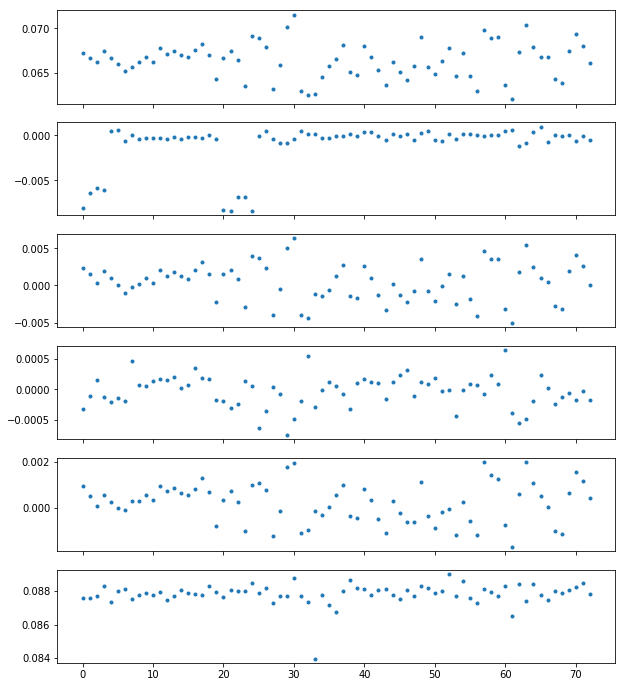

In [45]:
fig,axes = plt.subplots(nb+1,1,sharex=True,figsize=(10,2*(nb+1)))
for ib in range(nb+1):
    axes[ib].plot(obs_no,coeffs[:,ib],'.')    
    

In [46]:
ycor1 = np.zeros_like(y)
ycor2 = np.zeros_like(y)
for iobs in range(nobs):
    cof = np.zeros_like(coeffs[iobs,:])
    cof[2] = coeffs[iobs,2]-coeffs[iref,2]
    cof[3] = coeffs[iobs,3]-coeffs[iref,3]
    cof[4] = coeffs[iobs,4]-coeffs[iref,4]
    ycor1[iobs,:] = y[iobs,:] - np.dot(cof,basis)
    cof = np.zeros_like(coeffs[iobs,:])
    cof[1] = coeffs[iobs,1]-coeffs[iref,1]
    ycor2[iobs,:] = y[iobs,:] - np.dot(cof,basis)
    

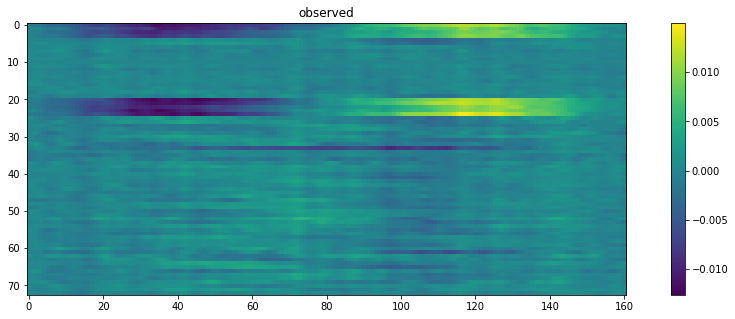

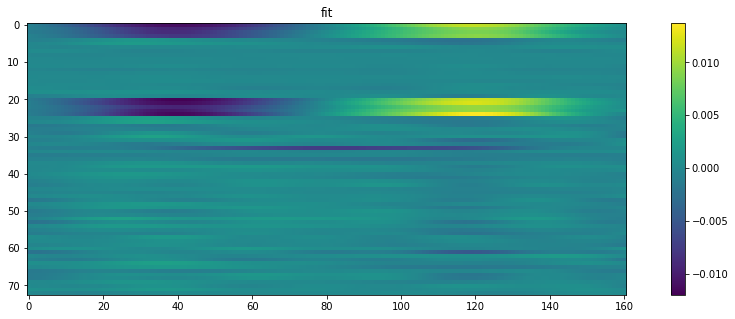

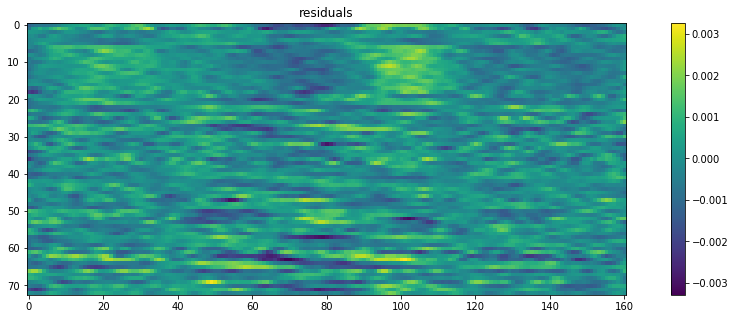

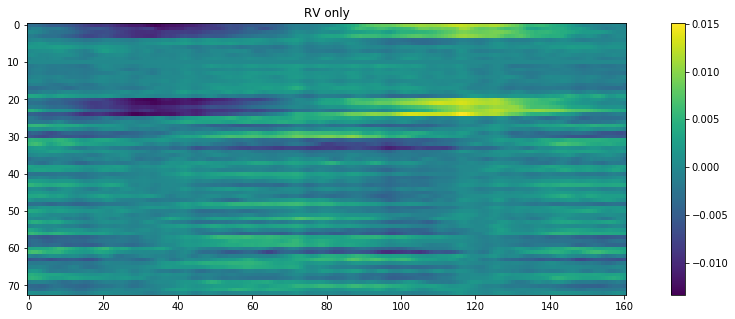

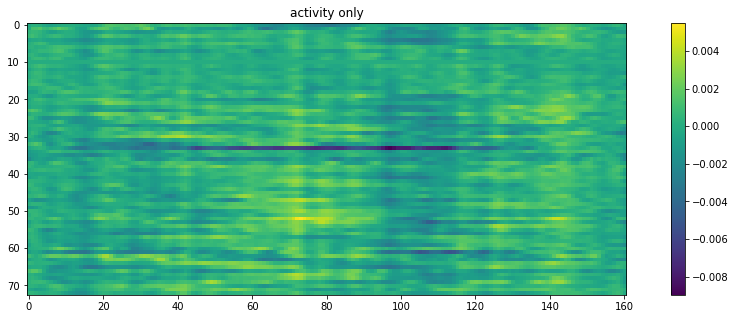

In [48]:
plt.figure(figsize=(16,5))
plt.title('observed')
plt.imshow((y-y[iref,:]))
plt.colorbar()

plt.figure(figsize=(16,5))
plt.title('fit')
plt.imshow((yfit-yfit[iref,:]))
plt.colorbar()

plt.figure(figsize=(16,5))
plt.title('residuals')
plt.imshow((y-yfit))
plt.colorbar()

plt.figure(figsize=(16,5))
plt.title('RV only')
plt.imshow((ycor1-y[iref,:]))
plt.colorbar()

plt.figure(figsize=(16,5))
plt.title('activity only')
plt.imshow((ycor2-y[iref,:]))
plt.colorbar()

In [49]:
np.savetxt('HARPSN_K2_100_CCF_coeffs_GP.txt',coeffs)